In [11]:
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ConstantSpectralModel,
    SkyModel,
    DiskSpatialModel,
    GeneralizedGaussianSpatialModel,
    GaussianSpatialModel,
    Models,
)
from gammapy.datasets import MapDataset
from gammapy.modeling import Fit
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

from modules import write_json, read_json, plot_results
from pathlib import Path

from os import chdir
import glob
import shutil
import json
import time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# Spatial and spectral models
spectra = 1
spatial = 0

if spectra == 0:
    spectral_model = ConstantSpectralModel(const="1e1 / (cm2 s TeV)")
else:
    spectral_model = PowerLawSpectralModel(
        index=2,
        amplitude="1e-11 TeV-1 cm-2 s-1",
        reference=1 * u.TeV,
    )

if spatial == 0:
    spatial_model = GaussianSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        sigma="1 deg",
        e=0.01,
        phi=0 * u.deg,
        frame="galactic",
    )
elif spatial == 1:
    spatial_model = DiskSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        r_0="1 deg",
        e=0.01,
        phi=0 * u.deg,
        edge_width=0.1,
        frame="galactic",
    )
else:
    spatial_model = GeneralizedGaussianSpatialModel(
        lon_0=0 * u.deg,
        lat_0=1.5 * u.deg,
        eta=.5,
        r_0=12 * u.deg,
        e=.999,
        phi=90 * u.deg,
        frame="galactic",
    )


In [13]:
timestr = time.strftime("%Y%m%d-%H%M%S")
(Path(timestr)).mkdir(parents = True)

# Create JSON file
with open(f"results_sliding_window.json", "w") as outfile:
    json.dump({}, outfile)

filename = "skymodel/global_skymodel_v1.0.yaml"
dataset = 'analysis_7'
cwd = Path.cwd()
path = cwd / 'datasets' / dataset

# Here you can change the "steps" of the sliding window
for i in np.arange(68, 79, 0.5):
    
    analysis = MapDataset.read(filename= path / f"{i}-dataset.fits.gz")

    chdir("..")

    models_read = Models.read(filename)
    models_read.remove("diffuse")
    models_read.freeze("spatial")
    
    region = CircleSkyRegion(
        center=SkyCoord(i, 0, unit="deg", frame="galactic"), radius=6.0 * u.deg
    )

    models_selected = models_read.select_region(region)

    model_config = SkyModel(spectral_model=spectral_model,
                            spatial_model=spatial_model, name="cygnus_background")

    models_selected.insert(0, model_config)

    analysis.models = models_selected
    analysis.models[0].parameters["lon_0"].frozen = True
    analysis.models[0].parameters["lon_0"].value = i
    analysis.models[0].parameters["lat_0"].max = 5
    analysis.models[0].parameters["lat_0"].min = -5
    #analysis.models[0].freeze("spectral")
    if spectra == 1:
    #    analysis.models[0].parameters["amplitude"].max = 1.e-11
        analysis.models[0].parameters["amplitude"].min = 1.e-16
    if spatial == 0:
        analysis.models[0].parameters["sigma"].max = 5
        analysis.models[0].parameters["sigma"].min = 0
    if spatial == 1:
        analysis.models[0].parameters["r_0"].max = 5
        analysis.models[0].parameters["r_0"].min = 0
        analysis.models[0].parameters["edge_width"].frozen = True
    if spatial == 1 or spatial == 0:
        analysis.models[0].parameters["e"].frozen = False
        analysis.models[0].parameters["phi"].frozen = True
    if spatial != 0 and spatial != 1:
        analysis.models[0].parameters["r_0"].frozen = True

    fit = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 1}
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    result_minuit = fit.run(analysis)

    results = {
        str(result_minuit.models[0].spatial_model.parameters["lon_0"].value): {
            "models": [analysis.models[0].spectral_model.tag[0], analysis.models[0].spatial_model.tag[0], dataset],
            "result": [result_minuit.optimize_result.success,
                       result_minuit.optimize_result.message,
                       result_minuit.optimize_result.total_stat],
            result_minuit.models[0].spectral_model.parameters[spectra].name: result_minuit.models[0].spectral_model.parameters[spectra].value,
        },
    }
    for j, ele in enumerate(result_minuit.models[0].spatial_model.parameters.names):
        if ele == "lon_0":
            continue
        results[str(result_minuit.models[0].spatial_model.parameters["lon_0"].value)] |= {
            ele: result_minuit.models[0].spatial_model.parameters[j].value
        }
        
    file_to_move = [f"model_{i}.yaml", f"model_{i}_covariance.dat"]
    result_minuit.models.write(file_to_move[0], overwrite=True)
    for file in file_to_move:
        shutil.move(file, cwd / f"{timestr}" / file)
        print('Moved:', file)
        
    chdir(cwd)
    write_json(results, "results_sliding_window.json")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (78.39700225, 2.57310706)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (78.39700225, 2.57310706)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
/home/antonio/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  resu

Moved: model_73.0.yaml
Moved: model_73.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False


Moved: model_73.5.yaml
Moved: model_73.5_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (79.6188337, 0.962326)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (79.6188337, 0.962326)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.74421481, -0.39832436)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.74421481, -0.39832436)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galact

Moved: model_74.0.yaml
Moved: model_74.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (80.246834, 1.20009)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.246834, 1.20009)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.223831, 1.02789112)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.223831, 1.02789112)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (79.6188337, 0.962326)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in

Moved: model_74.5.yaml
Moved: model_74.5_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (80.246834, 1.20009)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.246834, 1.20009)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.223831, 1.02789112)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (80.223831, 1.02789112)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b

Moved: model_75.0.yaml
Moved: model_75.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False


Moved: model_75.5.yaml
Moved: model_75.5_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Template file already exits, and overwrite is False


Moved: model_76.0.yaml
Moved: model_76.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (71.25236731, 0.93917696)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.25236731, 0.93917696)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
/home/antonio/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  resu

Moved: model_76.5.yaml
Moved: model_76.5_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (71.25236731, 0.93917696)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.25236731, 0.93917696)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.85383971, -2.76953932)> is outside valid IRF map range, using nearest IRF defined within
/home/antonio/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  resu

Moved: model_77.0.yaml
Moved: model_77.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (77.5, -3.06855373)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (77.5, -3.06855373)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (72.14074721, 0.56294407)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (72.14074721, 0.56294407)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (77.5, -2.60871224)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in 

Moved: model_77.5.yaml
Moved: model_77.5_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (78., -3.28079709)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (78., -3.28079709)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (83.74441972, 1.09785591)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (83.74441972, 1.09785591)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (72.14074721, 0.56294407)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b)

Moved: model_78.0.yaml
Moved: model_78.0_covariance.dat


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Position <SkyCoord (Galactic): (l, b) in deg
    (78.5, -3.23264708)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (78.5, -3.23264708)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (74.82317446, 0.45287649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (74.82317446, 0.45287649)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (74.92313583, 1.16526399)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, 

Moved: model_78.5.yaml
Moved: model_78.5_covariance.dat


In [14]:
file = "results_sliding_window.json"
shutil.move(file, f"{timestr}/" + file)
print('Moved:', file)

Moved: results_sliding_window.json


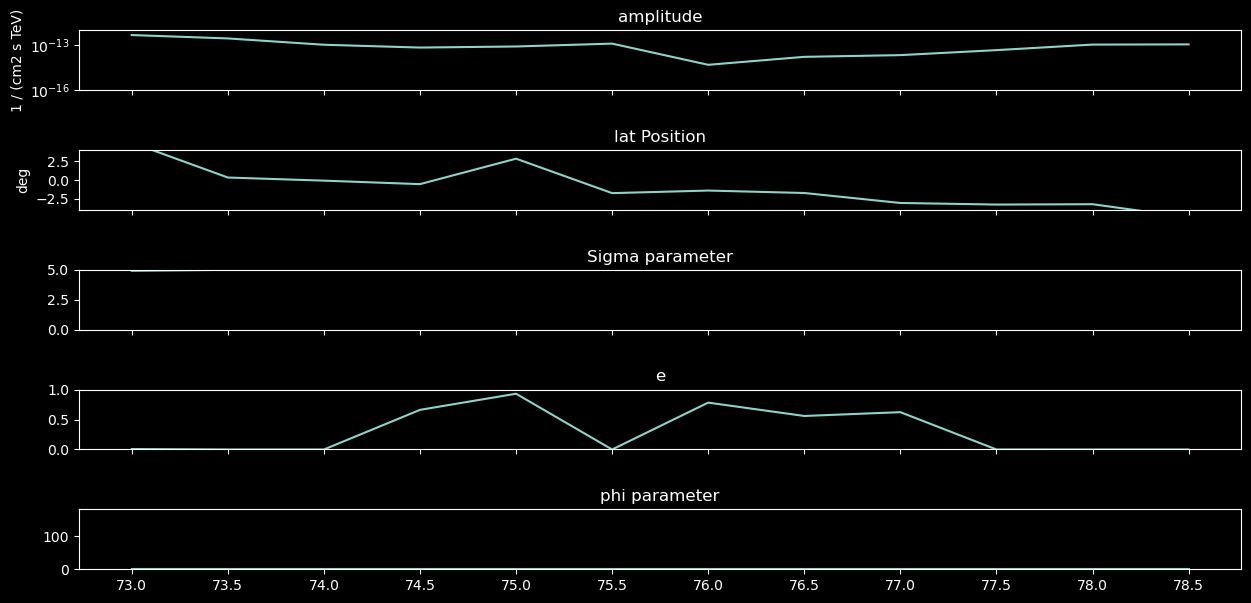

In [15]:
lists = read_json(f"{timestr}/results_sliding_window.json")
plot_results(lists, spectra, spatial)